In [7]:
import datetime
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader as DataLoader
from torchvision.transforms import Compose, Resize, ToTensor
from matplotlib import pyplot as plt
from melSpecDataset import MelSpecDataset
import basic_model as net0
import MusicRecNet as net1

In [8]:
#set run choices
loss_plot = True
verbose = True
epoch_save = False

# set variables
train_dir = './splitdata/training'
val_dir = './splitdata/testing'
#test_dir = './images/testing/'
gamma = 1
num_epochs = 10
batch_size = 64
learning_rate = 1
weight_decay = 1e-3
rho = 0.9
eps = 1e-06

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:


#need to change based on model name
#this calls the constructor of model class setting the choosen model for the run
################################################################################
#model = net0.GenreClassificationANN()
model = net1.MusicClassNet()

model.to(device)

################################################################################
#dataloader
resize_size = (128, 128)
transform = Compose([
    Resize(resize_size),
    ToTensor()
])

#training
train_dataset = MelSpecDataset(train_dir, transform)
data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

#validation
val_dataset = MelSpecDataset(val_dir, transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

#model optimizer
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=rho, eps=eps, weight_decay=weight_decay )

#model scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

# loss function
loss_function = nn.CrossEntropyLoss()

In [11]:
def train():
    model.train()
    model.to(device)

    epoch_losses = []
    epoch_losses_val = []
    n_images = 800
    n_batches = int(n_images/batch_size)
    n_batches_val = 1000-n_images-1 #removed an extra because of bad jazz sample

    for epoch in range(1, num_epochs+1):
        batch_loss = 0
        print(f'Epoch #{epoch}, Start Time: {datetime.datetime.now()}')

        #training
        model.train()
        for melspecs, labels in data_loader:
            
            #print(melspecs.shape)
            #print(labels)
            audios = melspecs.to(device)
            labels = labels.to(device)
        
            # calculate losses and call call model
            output = model(audios)
            
            # batch loss
            loss = loss_function(output, labels)
            batch_loss += loss.item()

            # backpropogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # save epoch loss
        epoch_losses += [batch_loss/n_batches]
        scheduler.step(epoch_losses[-1])
        
        
        #validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for melspecs, labels in val_loader:
                audios = melspecs.to(device)
                labels = labels.to(device)

                output = model(audios)

                # calculate losses
                loss = loss_function(output, labels)
                loss_val += loss.item()
        
        epoch_losses_val += [loss_val/n_batches_val]
        


        if verbose:
            print(f'Epoch: #{epoch}, Loss: {epoch_losses[epoch-1]}')
            print(f'Epoch: #{epoch}, Val_Loss: {epoch_losses_val[epoch - 1]}')

        if epoch_save:
            model_folder_dir = './temp_models'
            if not os.path.isdir(model_folder_dir):
                os.mkdir(model_folder_dir)

             # save temp model
            try:
                temp_model_path = model_folder_dir + '/' + str(datetime.datetime.now()) + '_epoch' + str(epoch) + '.pth'
                torch.save(model.state_dict(), temp_model_path)
                if verbose:
                    print(f'Saved model for epoch {epoch} @{temp_model_path}')
            except:
                print('Epoch model save failed')

    #save final model parameters   
    torch.save(model.state_dict(), f'model.pth')

    # save final loss plot
    if not os.path.exists("./plots"):
        os.makedirs("./plots")
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    #generate_loss_plot(epoch_losses, f'./plots/loss_plot_{timestamp}.png', show_plot=loss_plot)
    generate_loss_plot_with_val(epoch_losses, epoch_losses_val, f'./plots/loss_plot_{timestamp}.png', show_plot=loss_plot)

def generate_loss_plot(loss, file_loc, show_plot=False):
    epochs = list(range(1, len(loss)+1))
    plt.plot(epochs, loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.savefig(file_loc)
    if show_plot:
        plt.show()
    plt.close()

def generate_loss_plot_with_val(train_loss, val_loss, file_loc, show_plot=False): # loss plot with validation
    epochs = list(range(1, len(train_loss)+1))
    plt.plot(epochs, train_loss, label = "Training Loss")
    plt.plot(epochs, val_loss, label= "Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.savefig(file_loc)
    if show_plot:
        plt.show()
    plt.close()


Epoch #1, Start Time: 2023-12-03 01:24:36.660528
Epoch: #1, Loss: 13.106233338514963
Epoch: #1, Val_Loss: 0.18089712325053
Epoch #2, Start Time: 2023-12-03 01:25:03.618980
Epoch: #2, Loss: 10.561185558636984
Epoch: #2, Val_Loss: 0.1793833431886069
Epoch #3, Start Time: 2023-12-03 01:25:29.802200
Epoch: #3, Loss: 9.785085509220758
Epoch: #3, Val_Loss: 0.17931038291011026
Epoch #4, Start Time: 2023-12-03 01:25:56.256498
Epoch: #4, Loss: 9.429561545451483
Epoch: #4, Val_Loss: 0.17957217729271358
Epoch #5, Start Time: 2023-12-03 01:26:22.484757
Epoch: #5, Loss: 9.254234174887339
Epoch: #5, Val_Loss: 0.18003028721066575
Epoch #6, Start Time: 2023-12-03 01:26:46.789955
Epoch: #6, Loss: 8.813010285298029
Epoch: #6, Val_Loss: 0.17795279876670644
Epoch #7, Start Time: 2023-12-03 01:27:11.102387
Epoch: #7, Loss: 8.309757947921753
Epoch: #7, Val_Loss: 0.17549133240877085
Epoch #8, Start Time: 2023-12-03 01:27:35.466527
Epoch: #8, Loss: 8.08091632525126
Epoch: #8, Val_Loss: 0.17375710202221895
Epo

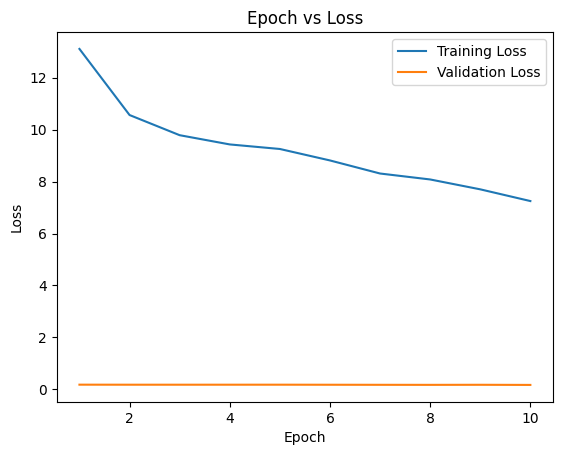

In [12]:
if __name__ == "__main__":
    train()